In [1]:
import importlib
import utils
import transformers
import models
import losses

In [2]:
from models import *
from utils import *

In [3]:
importlib.reload(utils)
importlib.reload(transformers)
importlib.reload(models)
importlib.reload(losses)

<module 'losses' from 'd:\\Documents\\machinelearning\\cgm-paper\\src\\losses.py'>

In [4]:
print("Current working directory: ", os.getcwd())

Current working directory:  d:\Documents\machinelearning\cgm-paper\src


In [5]:
raw_dir = "../data/raw"
tuning_dir = "../data/tuning"

In [6]:
assert os.path.exists(raw_dir), "Raw data directory not found"
assert os.path.exists(tuning_dir), "Tuning data directory not found"

In [7]:
dataset = load_data(raw_dir)

Found 22 files in ../data/raw
train (139415, 47)
test (32912, 47)


In [8]:
val_dataset = load_data(tuning_dir)

Found 2 files in ../data/tuning
train (13630, 43)
test (3002, 43)


In [9]:
for key in dataset.keys():
    val_dataset[key] = reduce_classes(val_dataset[key])
    dataset[key] = reduce_classes(dataset[key])

In [10]:
dataset.get("train")['Time'].isnull().sum()

0

In [11]:
train_data = get_train_dataset(dataset['train'])
test_data = get_any_dataset(dataset['test'], dataset['train'])

      CGM  month  day  hour  minute  weekday  cgm_velo  CGM(1)  CGM(2)  \
6    71.0      5   19    12       5        2  0.010000    66.0    64.5   
7    78.0      5   19    12      10        2  0.016667    71.0    68.5   
8    90.0      5   19    12      15        2  0.023333    78.0    74.5   
9    99.0      5   19    12      20        2  0.040000    90.0    84.0   
10  110.0      5   19    12      25        2  0.030000    99.0    94.5   

       CGM(3)  CGM(4)  CGM(5)     CGM(6)  
6   64.666667   65.50    66.8  68.333333  
7   66.666667   66.25    66.6  67.500000  
8   71.666667   69.50    68.6  68.500000  
9   79.666667   76.25    73.6  72.166667  
10  89.000000   84.50    80.8  77.833333  


The tuning data will be merged with the training data and be fitted into the pipeline to be used for the validation data

In [12]:
tuning_data = get_tuning_dataset(val_dataset['train'], dataset['train'])
val_data = get_any_dataset(val_dataset['test'], tuning_data)

In [13]:
models = Models()

In [14]:
trainX, trainY = train_data.drop(["CGM"], axis = 1), train_data["CGM"]
trainX.shape, trainY.shape

((123697, 12), (123697,))

In [15]:
testX, testY = test_data.drop(["CGM"], axis = 1), test_data["CGM"]
testX.shape, testY.shape

((28455, 12), (28455,))

In [16]:
testX.columns

Index(['month', 'day', 'hour', 'minute', 'weekday', 'cgm_velo', 'CGM(1)',
       'CGM(2)', 'CGM(3)', 'CGM(4)', 'CGM(5)', 'CGM(6)'],
      dtype='object')

In [17]:
testX.iloc[-3:, -1]

32909    151.500000
32910    150.666667
32911    149.833333
Name: CGM(6), dtype: float64

  0%|          | 0/8 [00:00<?, ?it/s]

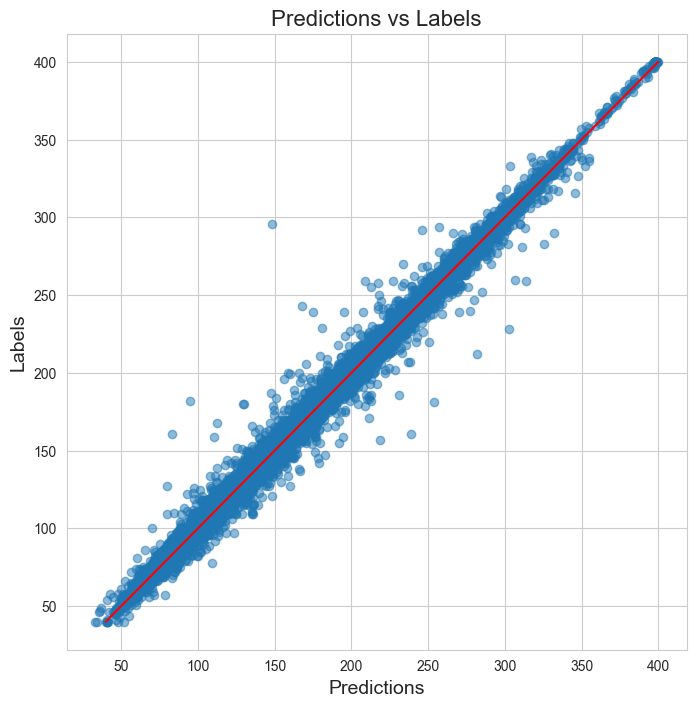

 12%|█▎        | 1/8 [00:00<00:01,  4.02it/s]

Ridge MSE: 19.413260272622868, RMSE: 4.406048146879794, MSPE: 0.0862696812822765 %


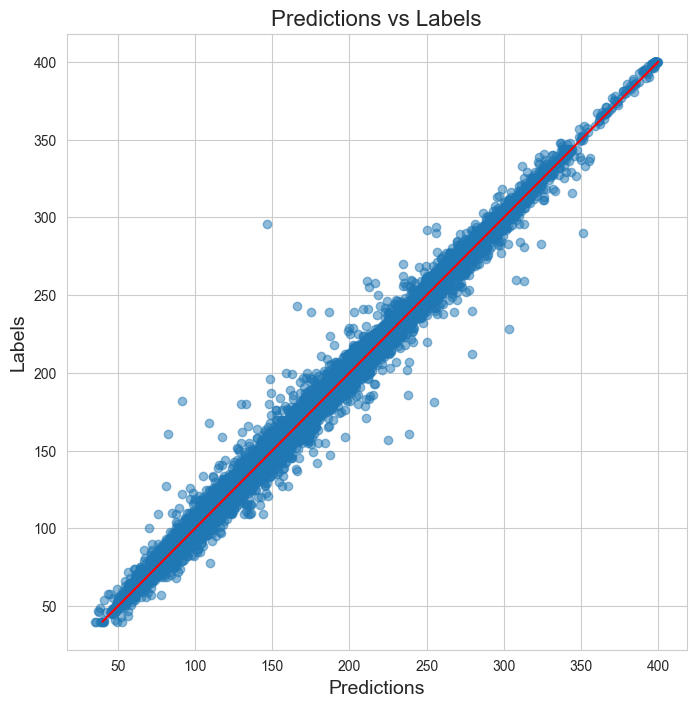

 25%|██▌       | 2/8 [00:03<00:13,  2.27s/it]

Lasso MSE: 20.850362910870622, RMSE: 4.5662197615610465, MSPE: 0.0930372768876917 %


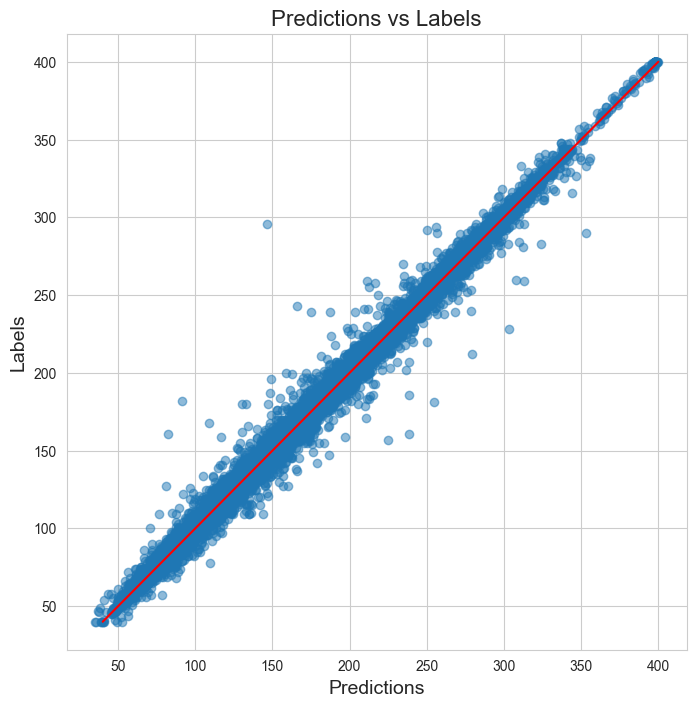

 38%|███▊      | 3/8 [00:08<00:17,  3.48s/it]

Elastic Net MSE: 20.76233657957461, RMSE: 4.556570703892853, MSPE: 0.09258036306403351 %


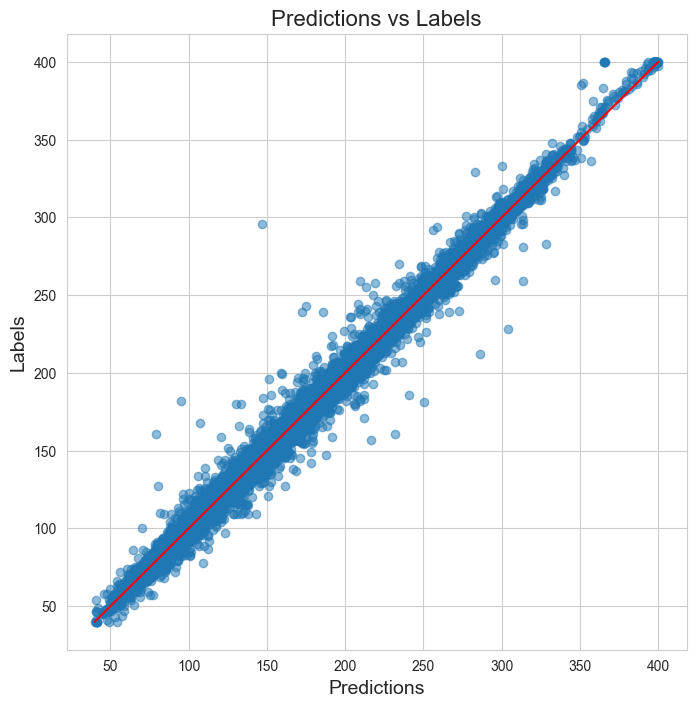

 50%|█████     | 4/8 [01:13<01:50, 27.62s/it]

Random Forest MSE: 20.73398984587681, RMSE: 4.553459107741807, MSPE: 0.09129096879875813 %


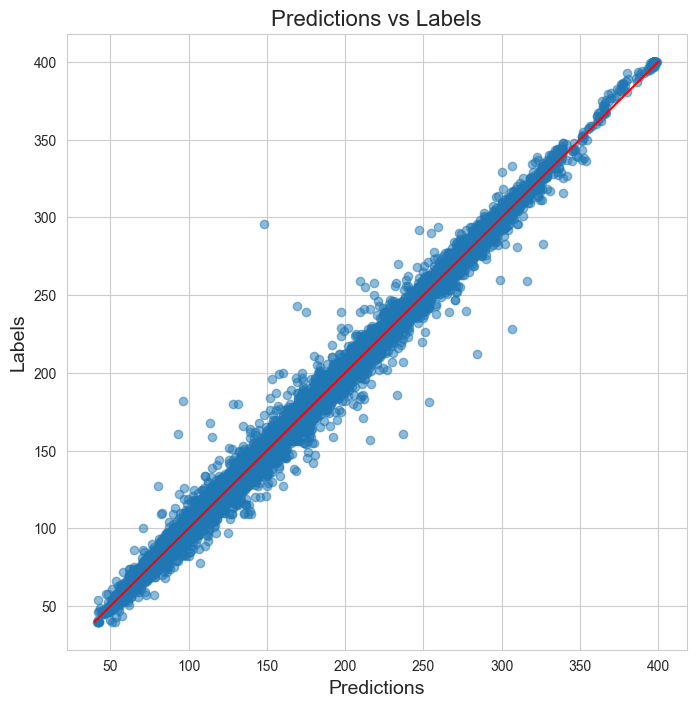

 62%|██████▎   | 5/8 [01:27<01:07, 22.58s/it]

Gradient Boosting MSE: 19.173221631278732, RMSE: 4.378723744572011, MSPE: 0.0855684974588132 %


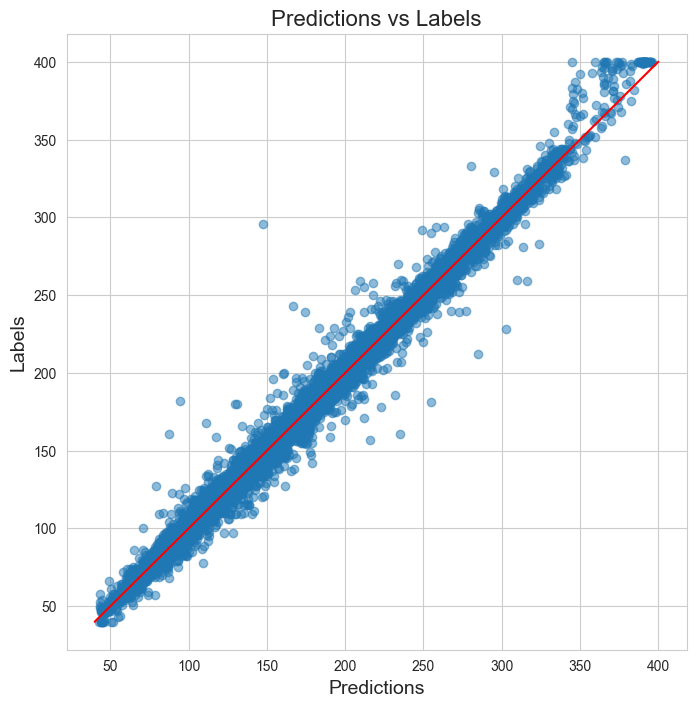

 75%|███████▌  | 6/8 [01:27<00:30, 15.07s/it]

XGBoost MSE: 21.700712394573824, RMSE: 4.6584023435695014, MSPE: 0.08981187579422874 %


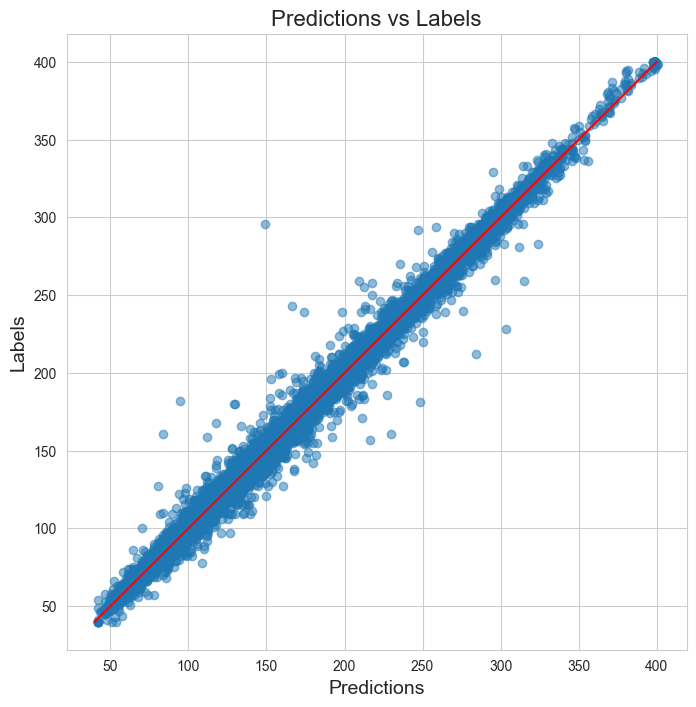

 88%|████████▊ | 7/8 [01:28<00:10, 10.32s/it]

LightGBM MSE: 18.80539329014221, RMSE: 4.3365185679462055, MSPE: 0.08458871243019242 %


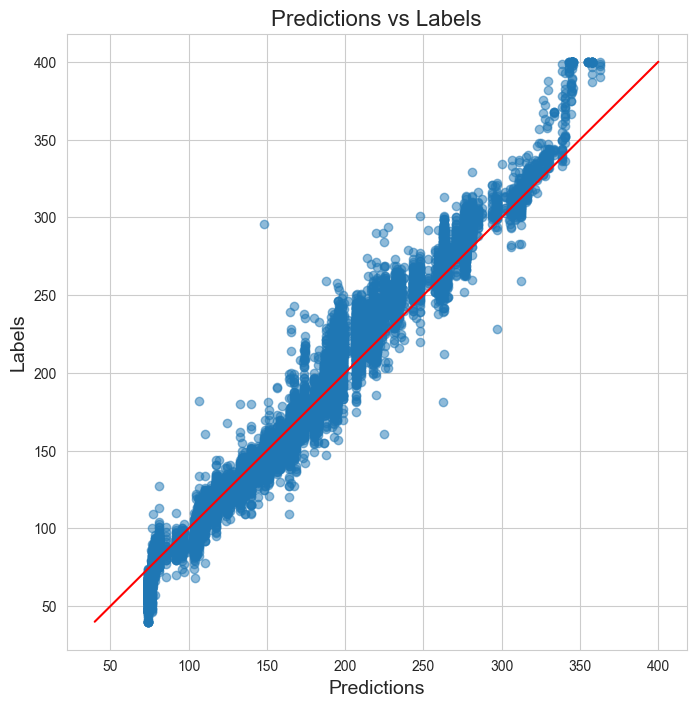

100%|██████████| 8/8 [01:34<00:00, 11.81s/it]

CatBoost MSE: 119.65879234971592, RMSE: 10.93886613638342, MSPE: 0.5985751894987249 %


In [18]:
models.fit(trainX, trainY, testX, testY)

In [19]:
models.forecast(testX, testY, 12)

d:\Documents\machinelearning\cgm-paper\src\utils.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = 2028
d:\Documents\machinelearning\cgm-paper\src\utils.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute']])
d:\Documents\machinelearning\cgm-paper\src\utils.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

,CGM
0,147.706841
1,147.044268
2,146.183100
3,145.571416
4,144.813220
...,...
91,77.538231
92,77.538231
93,77.538231
94,77.538231
